[[ 1.33211935  0.69088643  0.48195737 ... -1.12524354 -1.20370342
  -0.57432717]
 [ 1.31077633  0.76893365  0.37102166 ... -1.1377234  -1.05333352
  -0.62787766]]
Epoch 1/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 77ms/step - loss: 0.1140 - mae: 0.0364 - val_loss: 0.0620 - val_mae: 0.0023
Epoch 2/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0517 - mae: 0.0023 - val_loss: 0.0280 - val_mae: 0.0021
Epoch 3/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0238 - mae: 0.0021 - val_loss: 0.0147 - val_mae: 0.0016
Epoch 4/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0131 - mae: 0.0015 - val_loss: 0.0093 - val_mae: 0.0011
Epoch 5/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 0.0084 - mae: 0.0011 - val_loss: 0.0063 - val_mae: 7.3647e-04
Epoch 6/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0058 - mae: 6.8313e-04 - val_loss: 0.0044 - val_mae: 4.7219e-04
Epoch 7/25
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0040 - mae: 4.4633e-04 - val_loss: 0.0031 - val_mae: 3.0322e-0

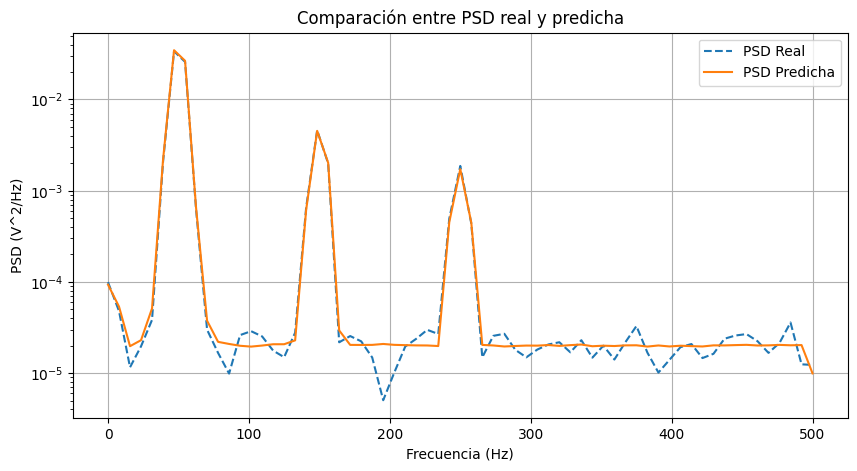

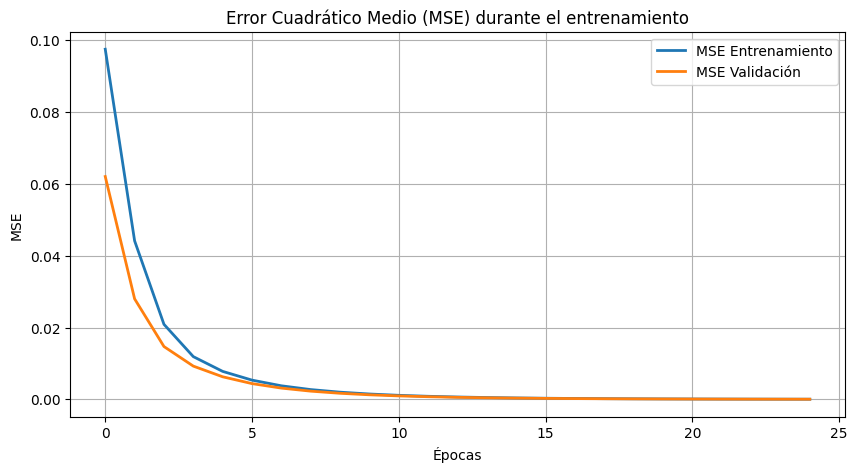

Error Relativo (%): 3.2952386450664646


In [2]:
# Importar bibliotecas necesarias
import numpy as np
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from keras.optimizers import Adam
from keras.regularizers import l2
from sklearn.model_selection import train_test_split
from scipy.signal import welch
import matplotlib.pyplot as plt

# ------------------------ Configuración de la señal base ------------------------

# Frecuencia de muestreo (Hz) y número de muestras
fs = 1000         # Frecuencia de muestreo
num_samples = 512 # Número de muestras

# Frecuencia base de la señal
f0 = 50  # Frecuencia base (Hz)

# Vector de tiempo para la señal
t = np.linspace(0, num_samples / fs, num_samples, endpoint=False)

# Crear una señal base compuesta de varias frecuencias
signal = (
    np.cos(2 * np.pi * f0 * t) -                # Componente principal
    (1/3) * np.sin(2 * np.pi * 3 * f0 * t) +   # Tercera armónica
    (1/5) * np.cos(2 * np.pi * 5 * f0 * t)     # Quinta armónica
)

# ------------------------ Generación del conjunto de datos ------------------------

# Listas para almacenar señales ruidosas (X) y sus PSD correspondientes (y)
X = []  # Señales ruidosas
y = []  # PSDs calculadas
noise_level = 0.1  # Nivel de ruido blanco
num_signals = 512  # Número total de señales a generar

# Generar señales ruidosas y calcular sus PSD usando Welch
for i in range(num_signals):
    # Añadir ruido blanco a la señal base
    noise = np.random.normal(0, noise_level, num_samples)
    noisy_signal = signal + noise  # Señal ruidosa

    # Agregar señal ruidosa al conjunto de datos
    X.append(noisy_signal)

    # Calcular la Densidad Espectral de Potencia (PSD) de la señal ruidosa
    freq, Pxx = welch(noisy_signal, fs, nperseg=128)
    y.append(Pxx)

# Convertir las listas de datos en matrices NumPy
X = np.array(X)  # Señales ruidosas
y = np.array(y)  # PSDs correspondientes

print(X[0:2])
# Redimensionar las señales para que sean compatibles con la entrada de la CNN
X = X[..., np.newaxis]

# Dividir los datos en entrenamiento (80%) y prueba (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# ------------------------ Construcción del modelo CNN ------------------------

# Definir el modelo secuencial
model = Sequential([
    
    # Primera capa convolucional  salida=vector muldimensional
    Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(num_samples, 1)),
    MaxPooling1D(pool_size=2),  # Reducción de dimensión mediante pooling / eliminar ruido 
    Dropout(0.2),  # Dropout para prevenir sobreajuste

    # Segunda capa convolucional  salida=vector muldimensional
    Conv1D(filters=64, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=1),
    Dropout(0.2),

    # Aplanar las características para tener compatibilidad capas densas
    Flatten(),

    # Primera capa densa completamente conectada con regularización L2
    Dense(64, activation='relu', kernel_regularizer=l2(0.001)), #Ajustar pesos, tenendolos pequeños
    
    # Capa de salida que coincide con el tamaño de la PSD
    Dense(y.shape[1])
])

# Compilar el modelo con el optimizador Adam, función de pérdida MSE, y métrica MAE
model.compile(optimizer=Adam(learning_rate=0.0005), loss='mse', metrics=['mae'])
                #ajustar pesos  ,  funcion de perdida,  metrica
                
# ------------------------ Entrenamiento del modelo ------------------------

# Entrenar el modelo y almacenar el historial del entrenamiento 
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=25, batch_size=32)

# ------------------------ Evaluación del modelo ------------------------

# Evaluar el modelo en el conjunto de prueba
test_loss, test_mae = model.evaluate(X_test, y_test)
print(f"Test Loss (MSE): {test_loss}, Test MAE: {test_mae}")

# ------------------------ Visualización de resultados ------------------------

# Seleccionar una señal aleatoria del conjunto de prueba
idx = np.random.randint(0, len(X_test))
y_pred = model.predict(X_test[idx][np.newaxis])  # Predicción para la señal seleccionada

# Gráfica de comparación entre la PSD real y la predicha
plt.figure(figsize=(10, 5))
plt.semilogy(freq, y_test[idx], label="PSD Real", linestyle="--")
plt.semilogy(freq, y_pred.flatten(), label="PSD Predicha", linestyle="-")
plt.title("Comparación entre PSD real y predicha")
plt.xlabel("Frecuencia (Hz)")
plt.ylabel("PSD (V^2/Hz)")
plt.legend()
plt.grid(True)
plt.show()

# ------------------------ Análisis del historial de entrenamiento ------------------------

# Extraer las pérdidas (MSE) de entrenamiento y validación
train_loss = history.history['loss']      # MSE en entrenamiento
val_loss = history.history['val_loss']   # MSE en validación

# Graficar las pérdidas durante las épocas
plt.figure(figsize=(10, 5))
plt.plot(train_loss, label="MSE Entrenamiento", linewidth=2)
plt.plot(val_loss, label="MSE Validación", linewidth=2)
plt.title("Error Cuadrático Medio (MSE) durante el entrenamiento")
plt.xlabel("Épocas")
plt.ylabel("MSE")
plt.legend()
plt.grid(True)
plt.show()

# ------------------------ Cálculo del error relativo ------------------------

# Calcular el error relativo entre la PSD real y la predicha
error_relativo = (np.sum(np.abs(y_test[idx] - y_pred.flatten())) / np.sum(np.abs(y_test[idx]))) * 100
print(f"Error Relativo (%): {error_relativo}")
